### Visualization of 5 random episodes

In [2]:
import gym

num_episodes = 5
env = gym.make("LunarLander-v2", continuous=False, enable_wind=False, turbulence_power=0.0, 
               render_mode='human', 
               max_episode_steps=500)

for i in range(num_episodes):
    state, info = env.reset();
    total_reward = 0
    num_steps = 0
    done = False
    truncated = False

    while not done and not truncated:
        action = env.action_space.sample()
        next_state, reward, done, truncated, info = env.step(action) 
        total_reward += reward
        num_steps += 1
        env.render()
        state = next_state

    print(f"Episode {i+1}: Reward {total_reward}, Steps {num_steps}")

env.close()

Episode 1: Reward -208.78898943474314, Steps 66
Episode 2: Reward -222.4024312670482, Steps 104
Episode 3: Reward -129.54853003403355, Steps 103
Episode 4: Reward -65.4062716935647, Steps 57
Episode 5: Reward -102.44696146372289, Steps 147


### Getting realistic observation space

In [ ]:
import numpy as np

num_episodes = 1000
env = gym.make("LunarLander-v2", continuous=False, enable_wind=False, turbulence_power=0.0, 
               max_episode_steps=500)

states = []

for episode in range(num_episodes):
    state, info = env.reset()
    
    done = False
    truncated = False

    while not done and not truncated:
        action = env.action_space.sample()
        next_state, reward, done, truncated, info = env.step(action)
        states.append(state)
        state = next_state

In [3]:
labels = ["x_coordinate","y_coordinate","x_velocity","y_velocity","angle","angular_velocity",
          "left_leg","right_leg"]
labels

['x_coordinate',
 'y_coordinate',
 'x_velocity',
 'y_velocity',
 'angle',
 'angular_velocity',
 'left_leg',
 'right_leg']

In [4]:
len(states)

91746

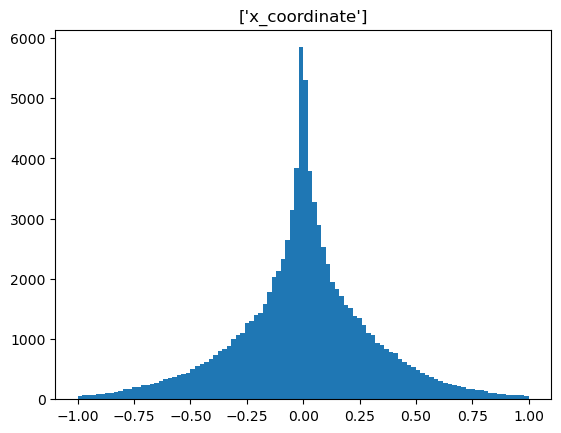

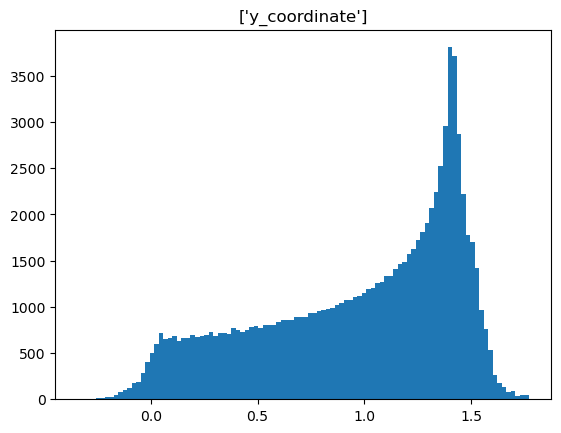

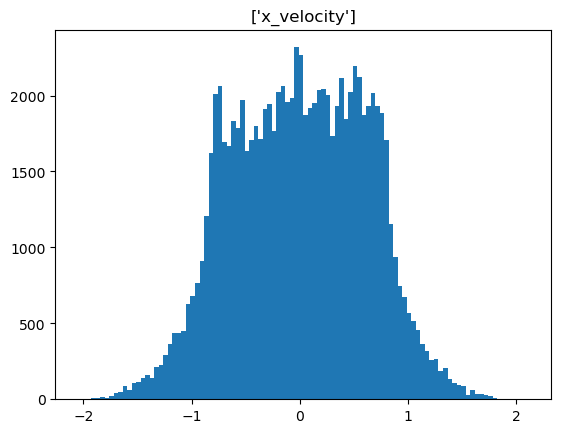

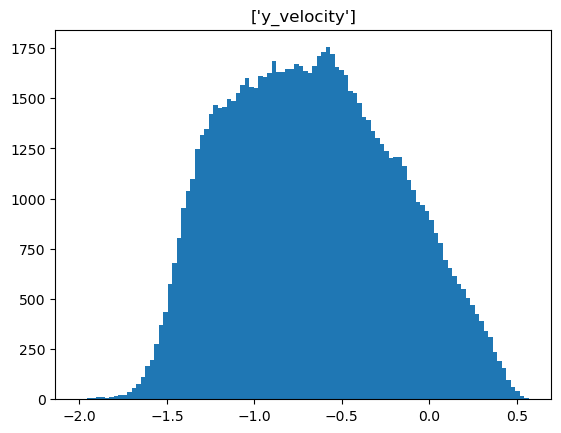

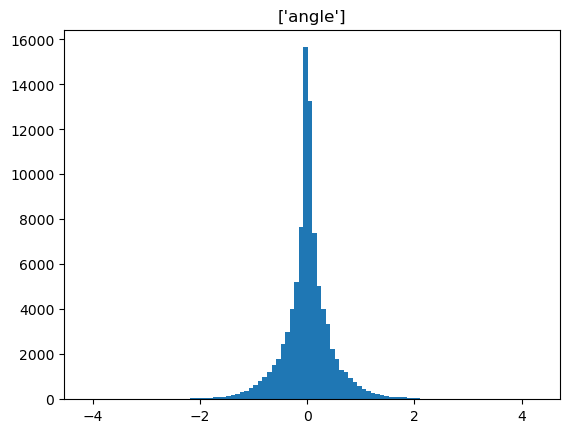

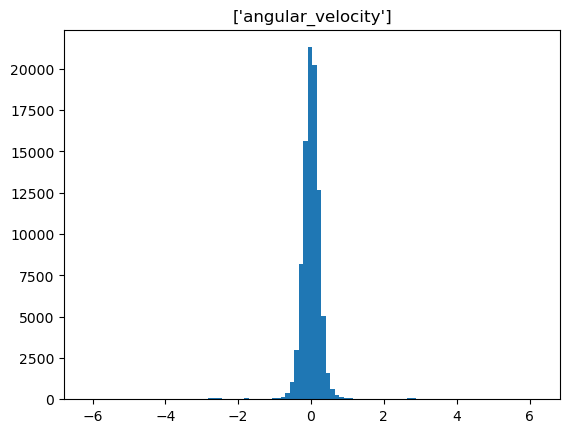

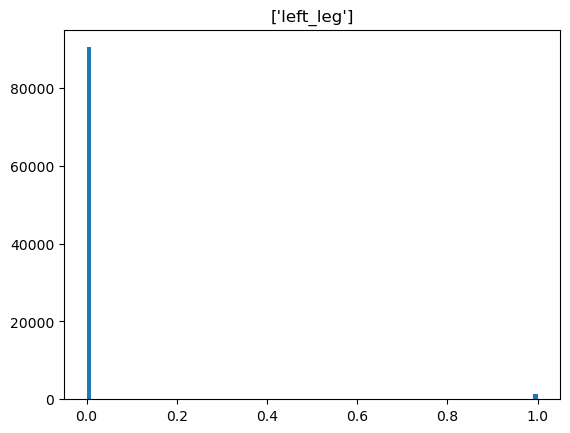

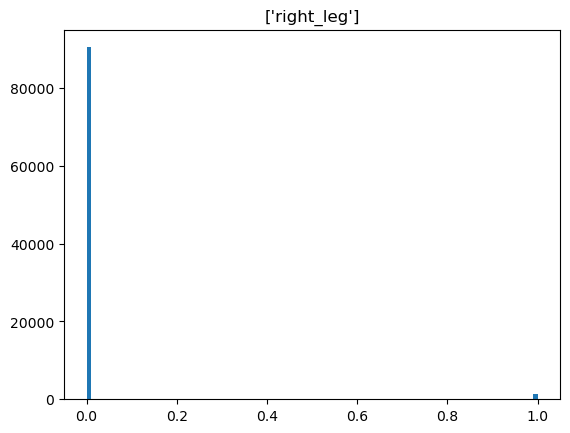

In [6]:
import matplotlib.pyplot as plt
for i in range(8):
    values = np.array(states)[:,i]   # all values for each element of obs space
    plt.hist(values,bins=100)
    plt.title([labels[i]])
    plt.show()

### Training The Agent

In [7]:
import numpy as np
import gym

np.random.seed(100)
env.action_space.seed(100)

num_bins = (15, 15, 15, 15, 10, 10, 2, 2)
obs_space = [np.linspace(-1,1,num_bins[0]), np.linspace(-.5,2,num_bins[1]),
                np.linspace(-2,2,num_bins[2]), np.linspace(-2,1,num_bins[3]),
                 np.linspace(-2,2,num_bins[4]), np.linspace(-2,2,num_bins[5]),
                 np.linspace(0,1,num_bins[6]), np.linspace(0,1,num_bins[7])]
env = gym.make("LunarLander-v2", continuous=False, enable_wind=False, turbulence_power=0.0, 
               max_episode_steps=500)
max_steps = 500


In [24]:
random_generator = np.random.default_rng(100)
# q_table = random_generator.uniform(-1,1,num_bins + (env.action_space.n,))
q_table = np.zeros((num_bins + (env.action_space.n,)))

In [4]:
def discretize_state(state: list[float]) -> tuple:
    '''Discretize the given observation state space by assigning each observation 
    to a discrete bin index (specified by obs_space). This is done to convert 
    the continuous observations to discrete observations, which is needed 
    for tabular Q-learning.'''

    state_idx = []
    for i in range(len(state)):
        digitized = np.digitize(state[i], obs_space[i]) - 1
        digitized = np.clip(digitized,0,num_bins[i] - 1)    #clip to the correct bounds
        state_idx.append(digitized)
    return tuple(state_idx)

In [6]:
lr = 0.05
eps = 1.0
eps_decay_constant = .0001228
min_eps = 0.01
gamma = 0.99
num_training_episodes = 100000

In [27]:
eps = 1.0
reward_history = []
success_history = []
for episode_num in range(num_training_episodes):
        state, info = env.reset(seed = int(np.random.uniform(low=1,high=1000)))
        state = discretize_state(state)
        done=False
        truncated=False
        rewards = 0

        for step in range(max_steps):
            if random_generator.random() < eps:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
                
            next_state, reward, done, truncated, info = env.step(action) 
            next_state = discretize_state(next_state)
            best_next_action = np.argmax(q_table[next_state])
            td_target = reward + gamma * q_table[next_state][best_next_action]
            q_table[state][action] += lr * (td_target - q_table[state][action])

            state=next_state
            rewards += reward

            if done or truncated:
                break
        
        if episode_num == 50000:    ##reset epsilon at halfway point
            eps = 1.0
        else:
             eps = max(min_eps, eps*np.e**(-eps_decay_constant))
            
        reward_history.append(rewards)
        success_history.append(int(rewards>=200))
            
        if ((episode_num+1) % 5000 == 0 and (episode_num+1)>=5000):
            print(f"Episodes {episode_num+1-100}-{episode_num+1}: Average Reward={np.mean(reward_history[-100:])}, Success Rate={np.sum(success_history[-100:])/100}, Epsilon = {eps}")
print(f"Total successes: {sum(success_history)}")

Episodes 4900-5000: Average Reward=-101.72254076131784, Success Rate=0.0, Epsilon = 0.5411818066152732
Episodes 9900-10000: Average Reward=-104.00936146170643, Success Rate=0.0, Epsilon = 0.2928777478113705
Episodes 14900-15000: Average Reward=-78.49215431897885, Success Rate=0.02, Epsilon = 0.15850010867796976
Episodes 19900-20000: Average Reward=-39.43350408090204, Success Rate=0.09, Epsilon = 0.08577737516306037
Episodes 24900-25000: Average Reward=-14.957866384628227, Success Rate=0.13, Epsilon = 0.04642115485746089
Episodes 29900-30000: Average Reward=5.770984297688392, Success Rate=0.04, Epsilon = 0.025122284450928005
Episodes 34900-35000: Average Reward=62.02412824851562, Success Rate=0.23, Epsilon = 0.013595723285455951
Episodes 39900-40000: Average Reward=74.57171885376043, Success Rate=0.28, Epsilon = 0.01
Episodes 44900-45000: Average Reward=82.35249932011747, Success Rate=0.35, Epsilon = 0.01
Episodes 49900-50000: Average Reward=97.2128945470604, Success Rate=0.43, Epsilon 

In [ ]:
np.save('q_table.npy', q_table)   ## Saving the trained agent

In [2]:
import numpy as np
import gym

trained_q_table = np.load('q_table.npy')

### Visualization of trained agent

In [12]:
num_episodes = 5
max_steps = 500
env = gym.make("LunarLander-v2", continuous=False, enable_wind=False, turbulence_power=0.0, 
               render_mode='human', 
               max_episode_steps=500)

for i in range(num_episodes):
    state, info = env.reset(seed=i);
    total_reward = 0
    num_steps = 0
    done = False
    truncated = False

    for step in range(max_steps):
        state = discretize_state(state)
        action = np.argmax(trained_q_table[state])
        next_state, reward, done, truncated, info = env.step(action) 
        env.render()
        total_reward += reward
        state = next_state

        if done or truncated:
            break
    print(f"Total Reward: {total_reward}")

env.close()

Total Reward: 278.729285675009
Total Reward: 217.34174240025843
Total Reward: 108.41468584695185
Total Reward: 225.16521648013796
Total Reward: 239.21854089536046


### Getting average performance over many episodes

In [10]:
total_reward = 0
successes = 0
env = gym.make("LunarLander-v2", continuous=False, enable_wind=False, turbulence_power=0.0, 
               # render_mode='human', 
               max_episode_steps=500)

for i in range(1000):
        state, info = env.reset(seed=int(np.random.uniform(low=1,high=1000)));
        done = False
        truncated = False
        rewards = 0

        for step in range(max_steps):
            state = discretize_state(state)
            action = np.argmax(trained_q_table[state])
            next_state, reward, done, truncated, info = env.step(action) 
            total_reward += reward
            rewards += reward
            state = next_state

            if done or truncated:
                break
            
        if (rewards > 200):
            successes += 1

print(f"Average Reward: {total_reward / 1000}")
print(f"Success Rate: {successes / 1000}")

Average Reward: 163.21839381664893
Success Rate: 0.605
